# Bitcoin Machine Learning Golden Cross Algorithmic Trading

## Background

In this workbook, we've trained support vector machine (SVM) model to make trading predictions, backtested the results, and then evaluated its performance compared to that of a logistic regression model for BTC.

## References

* [SKLearn SVM - SVC Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)

* [SKLearn LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

---

In [2]:
# Imports
import pandas as pd
import numpy as np
import hvplot.pandas
from pathlib import Path
import san

### Read the CSV file into Pandas DataFrame

In [3]:
# Pull the OHLCV dataset from Santiment into a Pandas Dataframe
trading_df = san.get(
    "ohlcv/bitcoin",
    from_date="2018-12-01",
    to_date="2021-12-01",
    interval="1d"
)

trading_df.columns = ['open', 'close', 'high', 'low', 'volume', 'marketcap']

# Review the DataFrame
trading_df.head()

open        close         high          low  \
datetime                                                                        
2018-12-01 00:00:00+00:00  4024.464242  4214.671932  4309.377312  3967.385777   
2018-12-02 00:00:00+00:00  4200.733180  4139.878064  4302.308536  4110.978473   
2018-12-03 00:00:00+00:00  4140.968062  3894.130907  4155.979284  3839.515704   
2018-12-04 00:00:00+00:00  3889.157782  3956.893870  4075.627655  3832.749938   
2018-12-05 00:00:00+00:00  3958.894725  3753.994827  3969.535852  3753.994827   

                                 volume     marketcap  
datetime                                               
2018-12-01 00:00:00+00:00  5.375314e+09  7.334619e+10  
2018-12-02 00:00:00+00:00  5.262698e+09  7.205049e+10  
2018-12-03 00:00:00+00:00  5.089571e+09  6.777905e+10  
2018-12-04 00:00:00+00:00  5.028069e+09  6.887829e+10  
2018-12-05 00:00:00+00:00  5.302482e+09  6.535250e+10

### Add a daily return values column to the DataFrame

In [4]:
# Calculate the daily returns using the closing prices and the pct_change function
trading_df["actual_returns"] = trading_df["close"].pct_change()

# Drop all NaN values from the DataFrame
trading_df = trading_df.dropna()

# Review the DataFrame
display(trading_df.head())
display(trading_df.tail())

open        close         high          low  \
datetime                                                                        
2018-12-02 00:00:00+00:00  4200.733180  4139.878064  4302.308536  4110.978473   
2018-12-03 00:00:00+00:00  4140.968062  3894.130907  4155.979284  3839.515704   
2018-12-04 00:00:00+00:00  3889.157782  3956.893870  4075.627655  3832.749938   
2018-12-05 00:00:00+00:00  3958.894725  3753.994827  3969.535852  3753.994827   
2018-12-06 00:00:00+00:00  3752.957618  3523.587653  3877.217892  3521.101724   

                                 volume     marketcap  actual_returns  
datetime                                                               
2018-12-02 00:00:00+00:00  5.262698e+09  7.205049e+10       -0.017746  
2018-12-03 00:00:00+00:00  5.089571e+09  6.777905e+10       -0.059361  
2018-12-04 00:00:00+00:00  5.028069e+09  6.887829e+10        0.016117  
2018-12-05 00:00:00+00:00  5.302482e+09  6.535250e+10       -0.051277  
2018-12-06 00:00:00+00:00  5.881809e+09  6.134725e+10       -0.061377

open         close          high  \
datetime                                                              
2021-11-27 00:00:00+00:00  53788.100861  54815.079305  55278.488924   
2021-11-28 00:00:00+00:00  54813.024702  57248.458376  57393.843751   
2021-11-29 00:00:00+00:00  57291.904735  57806.566215  58758.660146   
2021-11-30 00:00:00+00:00  57792.231501  57005.425474  59020.328590   
2021-12-01 00:00:00+00:00  56907.966734  57229.829899  59039.431694   

                                    low        volume     marketcap  \
datetime                                                              
2021-11-27 00:00:00+00:00  53741.326475  3.056086e+10  1.035176e+12   
2021-11-28 00:00:00+00:00  53680.466521  2.811689e+10  1.081180e+12   
2021-11-29 00:00:00+00:00  56856.369563  3.237084e+10  1.091774e+12   
2021-11-30 00:00:00+00:00  56089.483383  3.670859e+10  1.076689e+12   
2021-12-01 00:00:00+00:00  56553.080774  3.685820e+10  1.080978e+12   

                           actual_returns  
datetime                                   
2021-11-27 00:00:00+00:00        0.023247  
2021-11-28 00:00:00+00:00        0.044393  
2021-11-29 00:00:00+00:00        0.009749  
2021-11-30 00:00:00+00:00       -0.013859  
2021-12-01 00:00:00+00:00        0.003937

---

### Visualize Entries and Exits

In [5]:
# Import the finta Python library and the TA module
from finta import TA

In [6]:
# Create a signals_df DataFrame
signals_df = trading_df.copy()

# Set the short window and long windows
short_window = 50
long_window = 200

# Add the SMA technical indicators for the short and long windows
signals_df["sma_fast"] = TA.SMA(signals_df, short_window)
signals_df["sma_slow"] = TA.SMA(signals_df, long_window)

In [7]:
# Drop the NaNs using dropna()
signals_df = signals_df.dropna()
signals_df.head()

open         close          high  \
datetime                                                              
2019-06-19 00:00:00+00:00   9080.823672   9273.521766   9287.188201   
2019-06-20 00:00:00+00:00   9286.328862   9527.160350   9584.462069   
2019-06-21 00:00:00+00:00   9526.185593  10144.556717  10144.556717   
2019-06-22 00:00:00+00:00  10193.173489  10701.691013  11157.345516   
2019-06-23 00:00:00+00:00  10693.383969  10855.371016  11234.592857   

                                    low        volume     marketcap  \
datetime                                                              
2019-06-19 00:00:00+00:00   9070.395994  1.554681e+10  1.647809e+11   
2019-06-20 00:00:00+00:00   9233.407251  1.784682e+10  1.693048e+11   
2019-06-21 00:00:00+00:00   9526.185593  2.062401e+10  1.802932e+11   
2019-06-22 00:00:00+00:00  10116.124501  2.999520e+10  1.902141e+11   
2019-06-23 00:00:00+00:00  10556.944449  2.099833e+10  1.929701e+11   

                           actual_returns     sma_fast     sma_slow  
datetime                                                             
2019-06-19 00:00:00+00:00        0.021115  7713.055810  4969.832575  
2019-06-20 00:00:00+00:00        0.027351  7795.545075  4996.768986  
2019-06-21 00:00:00+00:00        0.064804  7888.325162  5028.021115  
2019-06-22 00:00:00+00:00        0.054920  7986.993194  5061.745101  
2019-06-23 00:00:00+00:00        0.014360  8087.477265  5097.251982

In [8]:
# Set the Signal column
signals_df["Signal"] = 0.0

# Generate the trading signal 1 or 0,
# where 1 is when the Short window is greater than (or crosses over) the Long Window
# where 0 is when the Short window is under the Long window
signals_df["Signal"][short_window:] = np.where(
    signals_df["sma_fast"][short_window:] > signals_df["sma_slow"][short_window:], 1.0, 0.0
)

# Calculate the points in time at which a position should be taken, 1 or -1
signals_df["Entry/Exit"] = signals_df["Signal"].diff()

# Review the DataFrame
signals_df.iloc[95:105, :]

open         close          high  \
datetime                                                              
2019-09-22 00:00:00+00:00  10024.647738  10067.962651  10073.875964   
2019-09-23 00:00:00+00:00  10070.054672   9729.323764  10070.054672   
2019-09-24 00:00:00+00:00   9728.995177   8620.566427   9803.319779   
2019-09-25 00:00:00+00:00   8605.701900   8486.992972   8740.531170   
2019-09-26 00:00:00+00:00   8474.726713   8118.967568   8515.685285   
2019-09-27 00:00:00+00:00   8112.357703   8251.845557   8271.269202   
2019-09-28 00:00:00+00:00   8249.052612   8245.915155   8284.027321   
2019-09-29 00:00:00+00:00   8256.404809   8104.226367   8256.404809   
2019-09-30 00:00:00+00:00   8099.885072   8293.867741   8314.230997   
2019-10-01 00:00:00+00:00   8295.019594   8343.276681   8497.692035   

                                   low        volume     marketcap  \
datetime                                                             
2019-09-22 00:00:00+00:00  9922.533395  1.320564e+10  1.807404e+11   
2019-09-23 00:00:00+00:00  9727.143574  1.514493e+10  1.746746e+11   
2019-09-24 00:00:00+00:00  8370.801382  2.500289e+10  1.547858e+11   
2019-09-25 00:00:00+00:00  8325.402358  2.174473e+10  1.524040e+11   
2019-09-26 00:00:00+00:00  7895.629623  1.925821e+10  1.458125e+11   
2019-09-27 00:00:00+00:00  7965.922654  1.640894e+10  1.482126e+11   
2019-09-28 00:00:00+00:00  8125.431663  1.414115e+10  1.481225e+11   
2019-09-29 00:00:00+00:00  7990.497160  1.303415e+10  1.455911e+11   
2019-09-30 00:00:00+00:00  7832.472354  1.711547e+10  1.490116e+11   
2019-10-01 00:00:00+00:00  8232.807081  1.530534e+10  1.499140e+11   

                           actual_returns      sma_fast     sma_slow  Signal  \
datetime                                                                       
2019-09-22 00:00:00+00:00        0.004815  10495.424404  8258.779991     1.0   
2019-09-23 00:00:00+00:00       -0.033635  10470.607194  8287.869189     1.0   
2019-09-24 00:00:00+00:00       -0.113960  10406.787622  8311.474760     1.0   
2019-09-25 00:00:00+00:00       -0.015495  10346.964095  8334.093156     1.0   
2019-09-26 00:00:00+00:00       -0.043363  10270.504080  8354.929995     1.0   
2019-09-27 00:00:00+00:00        0.016366  10196.212843  8376.657167     1.0   
2019-09-28 00:00:00+00:00       -0.000719  10123.900012  8398.340961     1.0   
2019-09-29 00:00:00+00:00       -0.017183  10058.904055  8419.328507     1.0   
2019-09-30 00:00:00+00:00        0.023400   9994.309822  8441.176001     1.0   
2019-10-01 00:00:00+00:00        0.005957   9933.523037  8463.087828     1.0   

                           Entry/Exit  
datetime                               
2019-09-22 00:00:00+00:00         0.0  
2019-09-23 00:00:00+00:00         0.0  
2019-09-24 00:00:00+00:00         0.0  
2019-09-25 00:00:00+00:00         0.0  
2019-09-26 00:00:00+00:00         0.0  
2019-09-27 00:00:00+00:00         0.0  
2019-09-28 00:00:00+00:00         0.0  
2019-09-29 00:00:00+00:00         0.0  
2019-09-30 00:00:00+00:00         0.0  
2019-10-01 00:00:00+00:00         0.0

In [9]:
# Visualize entry position relative to close price
entry = signals_df[signals_df["Entry/Exit"] == 1.0]["close"].hvplot.scatter(
    color='purple',
    marker='^',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize exit position relative to close price
exit = signals_df[signals_df["Entry/Exit"] == -1.0]["close"].hvplot.scatter(
    color='orange',
    marker='v',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize close price for the investment
security_close = signals_df[["close"]].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize moving averages
moving_avgs = signals_df[["sma_fast", "sma_slow"]].hvplot(
    ylabel='Price in $',
    width=1000,
    height=400
)

# Overlay plots
entry_exit_plot = security_close * moving_avgs * entry * exit
entry_exit_plot

:Overlay
   .Curve.I          :Curve   [datetime]   (close)
   .NdOverlay.I      :NdOverlay   [Variable]
      :Curve   [datetime]   (value)
   .Scatter.Close.I  :Scatter   [datetime]   (close)
   .Scatter.Close.II :Scatter   [datetime]   (close)

### Generating the Features and Target Sets

In [10]:
# Assign a copy of the sma_fast and sma_slow columns to a new DataFrame called X
X = signals_df[["sma_fast", "sma_slow"]].copy()

# Display sample data
display(X.head())
display(X.tail())

sma_fast     sma_slow
datetime                                           
2019-06-19 00:00:00+00:00  7713.055810  4969.832575
2019-06-20 00:00:00+00:00  7795.545075  4996.768986
2019-06-21 00:00:00+00:00  7888.325162  5028.021115
2019-06-22 00:00:00+00:00  7986.993194  5061.745101
2019-06-23 00:00:00+00:00  8087.477265  5097.251982

sma_fast      sma_slow
datetime                                             
2021-11-27 00:00:00+00:00  60733.733652  45983.186780
2021-11-28 00:00:00+00:00  60779.338331  46023.676402
2021-11-29 00:00:00+00:00  60840.038071  46064.128275
2021-11-30 00:00:00+00:00  60830.450791  46099.752736
2021-12-01 00:00:00+00:00  60854.226253  46152.100952

#### Create the target set

In [11]:
# Create a new column in the signals_df called signal setting its value to zero.
signals_df["signal"] = 0.0

In [12]:
# Create the signal to buy
signals_df.loc[(trading_df["actual_returns"] >= 0), "signal"] = 1

In [13]:
# Create the signal to sell
signals_df.loc[(trading_df["actual_returns"] < 0), "signal"] = -1

In [16]:
# Copy the new signal column to a new Series called y.
y = signals_df["signal"].copy()

---

### Split the Data Into Training and Testing Datasets

#### Creating the Training Datasets

In [17]:
# Imports 
from pandas.tseries.offsets import DateOffset

In [18]:
# Select the start of the training period
training_begin = X.index.min()

# Display the training begin date
print(training_begin)

2019-06-19 00:00:00+00:00


In [31]:
# Select the ending period for the training data with an offset of 3 months
training_end = X.index.min() + DateOffset(months=3)

# Display the training end date
print(training_end)

2019-09-19 00:00:00+00:00


In [32]:
# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Display sample data
X_train.head()

sma_fast     sma_slow
datetime                                           
2019-06-19 00:00:00+00:00  7713.055810  4969.832575
2019-06-20 00:00:00+00:00  7795.545075  4996.768986
2019-06-21 00:00:00+00:00  7888.325162  5028.021115
2019-06-22 00:00:00+00:00  7986.993194  5061.745101
2019-06-23 00:00:00+00:00  8087.477265  5097.251982

#### Creating the Testing Datasets

In [33]:
# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end:]
y_test = y.loc[training_end:]

# Display sample data
X_test.head()

sma_fast     sma_slow
datetime                                            
2019-09-19 00:00:00+00:00  10524.851472  8165.232394
2019-09-20 00:00:00+00:00  10520.490909  8197.356318
2019-09-21 00:00:00+00:00  10510.499681  8227.961461
2019-09-22 00:00:00+00:00  10495.424404  8258.779991
2019-09-23 00:00:00+00:00  10470.607194  8287.869189

#### Standardizing the Data

In [34]:
# Imports
from sklearn.preprocessing import StandardScaler

In [35]:
# Create a StandardScaler instance
scaler = StandardScaler()
 
# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)
 
# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

---

### Incorporate the SVM Machine Learning Into the Trading Strategy

In [36]:
# Imports
from sklearn import svm
from sklearn.metrics import classification_report

In [37]:
# Create the classifier model
svm_model = svm.SVC()
 
# Fit the model to the data using X_train_scaled and y_train
svm_model = svm_model.fit(X_train_scaled, y_train)

# Use the trained model to predict the trading signals for the training data
training_signal_predictions = svm_model.predict(X_train_scaled)

# Display the sample predictions
training_signal_predictions[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [38]:
# Evaluate the model using a classification report
training_report = classification_report(y_train, training_signal_predictions)
print(training_report)

              precision    recall  f1-score   support

        -1.0       0.62      0.52      0.56        46
         1.0       0.59      0.68      0.63        47

    accuracy                           0.60        93
   macro avg       0.60      0.60      0.60        93
weighted avg       0.60      0.60      0.60        93



---

### Backtesting a Machine Learning Trading Algorithm

In [39]:
# Use the trained model to predict the trading signals for the testing data.
testing_signal_predictions = svm_model.predict(X_test_scaled)

In [40]:
# Evaluate the model's ability to predict the trading signal for the testing data
svm_testing_report = classification_report(y_test, testing_signal_predictions)
print(svm_testing_report)

              precision    recall  f1-score   support

        -1.0       0.53      0.14      0.22       381
         1.0       0.53      0.89      0.67       424

    accuracy                           0.53       805
   macro avg       0.53      0.51      0.44       805
weighted avg       0.53      0.53      0.45       805



In [41]:
# Create a new empty predictions DataFrame using code provided below.
predictions_df = pd.DataFrame(index=X_test.index)
predictions_df["predicted_signal"] = testing_signal_predictions
predictions_df["actual_returns"] = signals_df["actual_returns"]
predictions_df["trading_algorithm_returns"] = predictions_df["actual_returns"] * predictions_df["predicted_signal"]
display(predictions_df.head())
display(predictions_df.tail())

predicted_signal  actual_returns  \
datetime                                                      
2019-09-19 00:00:00+00:00              -1.0        0.006684   
2019-09-20 00:00:00+00:00              -1.0       -0.008257   
2019-09-21 00:00:00+00:00              -1.0       -0.015904   
2019-09-22 00:00:00+00:00              -1.0        0.004815   
2019-09-23 00:00:00+00:00              -1.0       -0.033635   

                           trading_algorithm_returns  
datetime                                              
2019-09-19 00:00:00+00:00                  -0.006684  
2019-09-20 00:00:00+00:00                   0.008257  
2019-09-21 00:00:00+00:00                   0.015904  
2019-09-22 00:00:00+00:00                  -0.004815  
2019-09-23 00:00:00+00:00                   0.033635

predicted_signal  actual_returns  \
datetime                                                      
2021-11-27 00:00:00+00:00               1.0        0.023247   
2021-11-28 00:00:00+00:00               1.0        0.044393   
2021-11-29 00:00:00+00:00               1.0        0.009749   
2021-11-30 00:00:00+00:00               1.0       -0.013859   
2021-12-01 00:00:00+00:00               1.0        0.003937   

                           trading_algorithm_returns  
datetime                                              
2021-11-27 00:00:00+00:00                   0.023247  
2021-11-28 00:00:00+00:00                   0.044393  
2021-11-29 00:00:00+00:00                   0.009749  
2021-11-30 00:00:00+00:00                  -0.013859  
2021-12-01 00:00:00+00:00                   0.003937

<AxesSubplot:xlabel='datetime'>

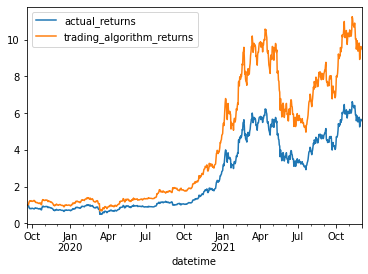

In [42]:
# Calculate and plot the cumulative returns for the `actual_returns` and the `trading_algorithm_returns`
(1 + predictions_df[["actual_returns", "trading_algorithm_returns"]]).cumprod().plot()

---

# Add a New Machine Learning Model

## Import the `LogisticRegression` model from scikit-learn.


In [43]:
# Import LogisticRegression from sklearn
from sklearn.linear_model import LogisticRegression

In [44]:
# Create an instance of the LogisticRegression model
logistic_regression_model = LogisticRegression()

## Using the same training data that the SVM model used (`X_train_scaled` and `y_train`), fit the `LogisticRegression` model.

In [45]:
# Fit the LogisticRegression model
logistic_regression_model.fit(X_train_scaled, y_train)

LogisticRegression()

## Use the trained model to predict the trading signals for the training data. Use the `classification_report` module to evaluate the model.

In [46]:
# Use the trained LogisticRegression model to predict the trading signals for the training data
lr_training_signal_predictions = logistic_regression_model.predict(X_train_scaled)

# Display the predictions
lr_training_signal_predictions

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1.])

In [47]:
# Generate a classification report using the training data and the logistic regression model's predications
lr_training_report = classification_report(y_train, lr_training_signal_predictions)

# Review the classification report
print(lr_training_report)

              precision    recall  f1-score   support

        -1.0       0.53      0.61      0.57        46
         1.0       0.55      0.47      0.51        47

    accuracy                           0.54        93
   macro avg       0.54      0.54      0.54        93
weighted avg       0.54      0.54      0.54        93



## Backtest the `LogisticRegression` model using the testing data to evaluate its performance.

In [48]:
# Use the trained model to predict the trading signals for the testing data.
lr_testing_signal_predictions = logistic_regression_model.predict(X_test_scaled)

In [49]:
# Generate a classification report using the testing data and the logistic regression model's predictions
lr_testing_report = classification_report(y_test, lr_testing_signal_predictions)

# Review the testing classification report
print(lr_testing_report)

              precision    recall  f1-score   support

        -1.0       0.48      0.91      0.62       381
         1.0       0.55      0.10      0.17       424

    accuracy                           0.48       805
   macro avg       0.51      0.50      0.40       805
weighted avg       0.51      0.48      0.38       805



## Compare the performance of the logistic regression and SVM models using the classification reports generated with the testing data. 

In [50]:
# Print the classification report for the Logistic Regression model using the test data
print("Logistic Regression Classification Report")
print(lr_testing_report)

Logistic Regression Classification Report
              precision    recall  f1-score   support

        -1.0       0.48      0.91      0.62       381
         1.0       0.55      0.10      0.17       424

    accuracy                           0.48       805
   macro avg       0.51      0.50      0.40       805
weighted avg       0.51      0.48      0.38       805



In [51]:
# Print the classification report for the SVM model using the test data
print("SVM Classification Report")
print(svm_testing_report)

SVM Classification Report
              precision    recall  f1-score   support

        -1.0       0.53      0.14      0.22       381
         1.0       0.53      0.89      0.67       424

    accuracy                           0.53       805
   macro avg       0.53      0.51      0.44       805
weighted avg       0.53      0.53      0.45       805



### Answer the following question:

**Question:** Did the `LogisticRegression` perform better than the `SVM`?

**Answer:** No! The SVM model performs a bit better than the logistic regression model since it has a higher accuracy score (53% to 48%).